In [1]:
#!/usr/bin/python
# -*- coding: iso-8859-15 -*-
# Author: adriamoya
# Adapted from https://github.com/sachinruk/deepschool.io/blob/master/DL-Keras_Tensorflow/Lesson%2007%20-%20Word2vec.ipynb

%matplotlib inline
import matplotlib.pyplot as plt

import re
import datetime
import numpy as np
import pandas as pd
import tensorflow as tf
from collections import Counter
from sklearn.manifold import TSNE

/Users/moyandreu/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
# load data
df = pd.read_csv("/Users/moyandreu/.kaggle/competitions/bcpnews/train.csv")
df_test = pd.read_csv("/Users/moyandreu/.kaggle/competitions/bcpnews/test.csv")

In [6]:
def preprocessing(df, column="text"):

    """ Preprocessing (lower case, remove urls, punctuations) """

    print("\nPreprocessing %s ..." % column)

    # preprocessing steps: lower case, remove urls, punctuations ...
    df[column] = df[column].str.lower()
    df[column] = df[column].str.replace(r'http[\w:/\.]+','') # remove urls
    df[column] = df[column].str.replace(r'[^\.(a-zA-ZÀ-ÿ0-9)\s]','') #remove everything but characters and punctuation ( [^\.\w\s] )
    df[column] = df[column].str.replace(r'(?<=\d)(\.)(?=\d)','') #remove dots in thousands (careful with decimals!)
    df[column] = df[column].str.replace(r'\.\.+','.') #replace multple periods with a single one
    df[column] = df[column].str.replace(r'\.',' .') #replace multple periods with a single one
    df[column] = df[column].str.replace(r'\(',' ') # replace brackets with white spaces
    df[column] = df[column].str.replace(r'\)',' ') # replace brackets with white spaces
    df[column] = df[column].str.replace(r'\s\s+',' ') #replace multple white space with a single one
    df[column] = df[column].str.strip()

    return df

In [7]:
df = preprocessing(df, 'text')


Preprocessing text ...


In [8]:
all_text = ''.join(df.text.values)
words = all_text.split()

In [9]:
len(words)

7969637

In [10]:
vocabulary_size = 50000

def build_dataset(words):
    count = [['UNK', -1]]
    count.extend(Counter(words).most_common(vocabulary_size - 1))
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)
    data = list()
    unk_count = 0
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0  # dictionary['UNK']
            unk_count = unk_count + 1
        data.append(index)
    count[0][1] = unk_count
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
    return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
del words  # Hint to reduce memory.

Most common words (+UNK) [['UNK', 110829], ('de', 575428), ('la', 304341), ('.', 258977), ('el', 252128)]
Sample data [9, 1029, 1281, 10, 33, 1, 2425, 31, 2328, 534]


In [11]:
%%time
skip_window = 1
instances = len(data) - 2*skip_window
context = np.zeros((instances,skip_window*2+1),dtype=np.int32)
labels = np.zeros((instances,1),dtype=np.int32)

k = 0
for i in range(skip_window, len(data)-skip_window):
    context[k] = data[i-skip_window:i+skip_window+1] # Get surrounding words
    labels[k] = data[i] # Get target variable
    k += 1
    
context = np.delete(context,skip_window,1) # delete the middle word
    
############################
# Chunk the data to be passed into the tensorflow Model
###########################
data_idx = 0
def generate_batch(batch_size):
    global data_idx

    if data_idx+batch_size<instances:
        batch_labels = labels[data_idx:data_idx+batch_size]
        batch_word_data = context[data_idx:data_idx+batch_size]
        data_idx += batch_size
    else:
        overlay = batch_size - (instances-data_idx)
        batch_labels = np.vstack([labels[data_idx:instances],labels[:overlay]])
        batch_word_data = np.vstack([context[data_idx:instances],context[:overlay]])
        data_idx = overlay
    batch_word_data = np.reshape(batch_word_data,(-1,1))

    return batch_labels, batch_word_data

CPU times: user 11.6 s, sys: 83.4 ms, total: 11.7 s
Wall time: 11.7 s


In [12]:
print([reverse_dictionary[bi] for bi in data[:40]])

['los', 'nueve', 'consejeros', 'del', 'banco', 'de', 'inglaterra', 'han', 'acordado', 'mantener', 'los', 'tipos', 'de', 'interés', 'en', 'el', '025', '.', 'su', 'mayor', 'optimismo', 'sobre', '2017', 'enfría', 'las', 'opciones', 'de', 'una', 'futura', 'rebaja', 'de', 'tipos', '.', 'la', 'reunión', 'del', 'banco', 'de', 'inglaterra', 'ha']


In [13]:
len(data)

7969637

In [15]:
labels_, batch = generate_batch(20)
print('batch:\t', [reverse_dictionary[bi] for bi in batch.ravel()])
print('labels:\t', [reverse_dictionary[li] for li in labels_.ravel()])

batch:	 ['optimismo', '2017', 'sobre', 'enfría', '2017', 'las', 'enfría', 'opciones', 'las', 'de', 'opciones', 'una', 'de', 'futura', 'una', 'rebaja', 'futura', 'de', 'rebaja', 'tipos', 'de', '.', 'tipos', 'la', '.', 'reunión', 'la', 'del', 'reunión', 'banco', 'del', 'de', 'banco', 'inglaterra', 'de', 'ha', 'inglaterra', 'dejado', 'ha', 'sin']
labels:	 ['sobre', '2017', 'enfría', 'las', 'opciones', 'de', 'una', 'futura', 'rebaja', 'de', 'tipos', '.', 'la', 'reunión', 'del', 'banco', 'de', 'inglaterra', 'ha', 'dejado']


Shuffle data:

In [16]:
data_idx = 0
shuffle_idx = np.random.permutation(instances) # create a random permutation to shuffle
labels = labels[shuffle_idx]
context = context[shuffle_idx]

# Tensorflow model: (Continuous Bag of Words - CBoW)

In [17]:
context_window = 2*skip_window
batch_size = 128*context_window
embedding_size = 128 # Dimension of the embedding vector.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_examples = np.random.choice(100,16,replace=False) # Choose 16 words from top 100
num_sampled = 64 # Number of negative examples to sample.

sum_ids = np.repeat(np.arange(batch_size/context_window, dtype=np.int32),context_window)

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):
    # Input data.
    train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size/context_window, 1])
    segment_ids = tf.constant(sum_ids, dtype=tf.int32)
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

    # Variables.
    embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    softmax_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size],
                             stddev=1.0 / np.sqrt(embedding_size)))
    softmax_biases = tf.Variable(tf.zeros([vocabulary_size]),trainable=False)

    # Model.
    # Look up embeddings for inputs.
    embed = tf.segment_mean(tf.nn.embedding_lookup(embeddings, train_dataset),segment_ids)
    # Compute the softmax loss, using a sample of the negative labels each time.
    loss = tf.reduce_mean(tf.nn.sampled_softmax_loss(softmax_weights, softmax_biases, inputs=embed,
                                   labels = train_labels, num_sampled = num_sampled, num_classes = vocabulary_size))

    # Optimizer.
    optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)

    # Compute the similarity between minibatch examples and all embeddings.
    # We use the cosine distance:
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
    similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [18]:
num_steps = 200001

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print('Initialized')
    average_loss = 0
    for step in range(num_steps):
        batch_labels, batch_data = generate_batch(int(batch_size/context_window))
        feed_dict = {train_dataset : batch_data.ravel(), train_labels : batch_labels}
        _, l = session.run([optimizer, loss], feed_dict=feed_dict)
        ############
        # Calculate average loss (every 2000 steps)
        ################
        average_loss += l
        if step % 2000 == 0:
            if step > 0:
                average_loss = average_loss / 2000
            # The average loss is an estimate of the loss over the last 2000 batches.
            print('Average loss at step %d: %f' % (step, average_loss))
            average_loss = 0
        ####################
        
        ##################
        # Check with the validation set (every 10000 steps)
        ##################
        if step % 10000 == 0:
            sim = similarity.eval()
            for i in range(len(valid_examples)):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 8 # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                log = 'Nearest to %s:' % valid_word
                for k in range(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log = '%s %s,' % (log, close_word) # append the k-the nearest word
                print(log)

    final_embeddings = normalized_embeddings.eval()

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Initialized
Average loss at step 0: 8.077648
Nearest to vez: homosexual, testificales, injustificable, europeu, estirón, navara, dei, devolverla,
Nearest to desde: carentes, fichada, moscú, repostería, terapias, barnés, verificada, públicoprivada,
Nearest to presidente: urgió, 1035, edimburgo, elevó, pida, inscrita, turquesa, depositados,
Nearest to han: customers, zone, limón, ibi, predominio, alineación, exceder, chomón,
Nearest to sus: contenta, pensarán, ontario, panay, logró, dividida, mauritshuis, pedagógico,
Nearest to cada: detallaremos, reacondicionados, desparpajo, despegue, franca, alumnos, mármol, acudiendo,
Nearest to millones: maaemo, cifras, asada, arsa, robustos, importadores, interrumpe, christopher,
Nearest to también: extracción, chance, constan, 420, quevedo, transformaciones, alianzas, sujetas,
Nearest to parte: electrodomésticos, 226000, bajará, wars, sangrante, derrochar, karmele, pge,
Near

Average loss at step 42000: 2.439978
Average loss at step 44000: 2.418543
Average loss at step 46000: 2.406980
Average loss at step 48000: 2.388251
Average loss at step 50000: 2.380268
Nearest to vez: ronda, entrevista, rebollo, compraron, soviético, orlando, minecraft, cifrada,
Nearest to desde: hasta, en, durante, según, descentralizada, desahogo, r, explicando,
Nearest to presidente: director, vicepresidente, ico, ministro, don, turquesa, brent, secretario,
Nearest to han: ha, había, hemos, habían, habría, haya, hayan, he,
Nearest to sus: nuestros, los, las, nuestras, esas, estas, nuevos, esos,
Nearest to cada: sabiendo, wert, sorprendente, turbina, angustia, mattarella, gran, satse,
Nearest to millones: euros, puntos, personas, dólares, metros, unidades, kilómetros, equipamientos,
Nearest to también: además, ya, actualmente, sí, no, espetó, trienio, cómo,
Nearest to parte: stella, raisin, seas, encima, atravesaba, hensarling, sum, ejemplo,
Nearest to hasta: desde, tras, 1790, guita

Average loss at step 102000: 2.151777
Average loss at step 104000: 2.145719
Average loss at step 106000: 2.145118
Average loss at step 108000: 2.134800
Average loss at step 110000: 2.128889
Nearest to vez: rebollo, ronda, soviético, pulsión, hoy, produciría, entrevista, cifrada,
Nearest to desde: hasta, desahogo, según, durante, explicando, gasística, afronta, en,
Nearest to presidente: vicepresidente, director, ministro, consejero, secretario, responsable, ico, brent,
Nearest to han: ha, habían, había, hayan, hemos, habría, haya, he,
Nearest to sus: nuestros, nuestras, tus, los, las, mis, esas, dichas,
Nearest to cada: turbina, cualquier, sabiendo, coinc, solo, saénz, incursión, mattarella,
Nearest to millones: puntos, metros, personas, unidades, dólares, euros, kilómetros, empleados,
Nearest to también: además, actualmente, tampoco, indignación, viñas, sí, elvira, territorialidad,
Nearest to parte: stella, raisin, machi, hensarling, encima, sum, jefe, ejemplo,
Nearest to hasta: desde

Average loss at step 152000: 2.027735
Average loss at step 154000: 2.024818
Average loss at step 156000: 2.031024
Average loss at step 158000: 2.023264
Average loss at step 160000: 2.024994
Nearest to vez: pulsión, rebollo, hoy, produciría, ronda, soviético, injustificable, orlando,
Nearest to desde: hasta, según, gasística, desahogo, explicando, hellman, precipitadamente, durante,
Nearest to presidente: vicepresidente, director, ministro, consejero, secretario, responsable, diputado, expresidente,
Nearest to han: ha, habían, hayan, había, hemos, habría, haya, hubieran,
Nearest to sus: nuestros, tus, nuestras, mis, las, los, esas, dichas,
Nearest to cada: coinc, turbina, cualquier, apenas, saénz, solo, sabiendo, alimentó,
Nearest to millones: puntos, metros, unidades, personas, kilómetros, billones, dólares, empleados,
Nearest to también: además, actualmente, tampoco, indignación, viñas, territorialidad, a320neo, igualmente,
Nearest to parte: raisin, stella, machi, convicción, hensarli

In [14]:
final_embeddings.shape

(50000, 128)

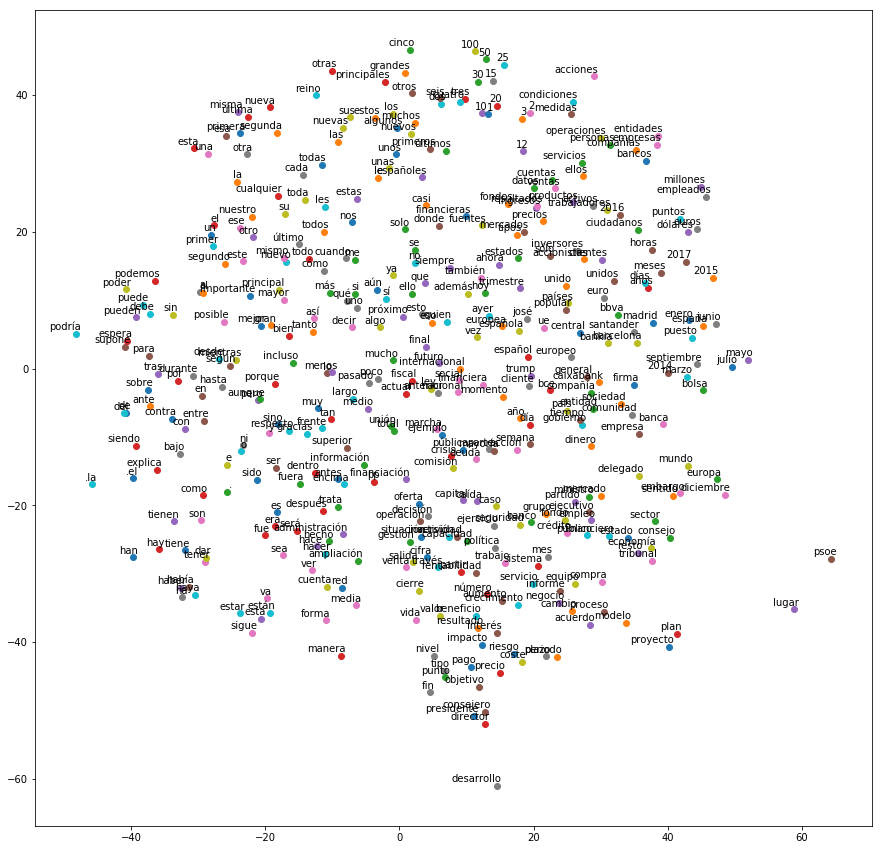

In [15]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

def plot(embeddings, labels):
    plt.figure(figsize=(15,15))  # in inches
    for i, label in enumerate(labels):
        x, y = embeddings[i,:]
        plt.scatter(x, y)
        plt.annotate(label.decode('utf8'), xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
    plt.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

In [22]:
final_embeddings[0]

array([ 6.94914460e-02,  4.42465283e-02, -7.42352828e-02,  1.01415720e-02,
       -3.58189568e-02, -5.85301220e-02, -4.90535013e-02, -1.23210654e-01,
       -1.23552047e-01,  7.31641278e-02, -5.59075065e-02,  3.92964436e-03,
       -8.75197053e-02, -2.74978299e-02, -1.36804534e-02,  8.99771377e-02,
       -4.10998352e-02,  7.20975995e-02, -4.71039824e-02,  1.22763284e-01,
        4.15167101e-02,  1.00400053e-01, -1.38550803e-01, -3.84866185e-02,
       -1.30468518e-01, -2.72211921e-03,  9.07721221e-02,  1.99481979e-01,
       -2.28903979e-01, -7.77671114e-02, -1.05138794e-01, -8.30048695e-02,
        4.97830398e-02, -3.49698646e-04, -3.14399637e-02,  1.11660741e-01,
       -5.48855439e-02, -7.50376806e-02,  7.89282396e-02, -8.29311386e-02,
        9.19567272e-02,  1.91365350e-02,  4.47493717e-02,  2.01844107e-02,
        6.74371645e-02,  2.06936181e-01,  5.63977333e-03,  5.77792004e-02,
        1.70167089e-01,  1.43169090e-01,  5.80377020e-02, -1.36544695e-02,
        6.64065545e-03, -